# Решение задачи про Battle Fury на Anti-Mage 

Портал https://www.opendota.com/ предоставляет доступ к базе данных с анализами профессиональных матчей Dota 2.

Необходимо составить SQL-запросы к базе данных для выгрузки 1000 профессиональных матчей за последний патч 7.07 с
https://www.opendota.com/explorer, а также 1000 последних матчей из прошлого патча 7.06. 
Среди всех матчей выбрать те, в которых есть герой Anti-Mage (hero_id = 1). 
Для данного героя нужно вывести значение времени покупки предмета battle fury (‘bfury’ в purchase_log) от начала матча. 
Далее необходимо провести статистический для проверки гипотезы о том, что в среднем время покупки предмета для обоих патчей одинаково.

API: https://docs.opendota.com/ 

Схема БД: https://github.com/odota/core/blob/master/sql/create_tables.sql

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import json

from opendota import query_opendota

In [2]:
def query_table(patch_start, patch_end):
    SQL = '''
    SELECT
        matches.match_id,
        matches.start_time,
        matches.duration,
        ((player_matches.player_slot < 128) = matches.radiant_win) win,
        player_matches.hero_id,
        player_matches.account_id,
        player_matches.purchase_log,
        leagues.name leaguename
    FROM matches
        JOIN match_patch using(match_id)
        JOIN leagues using(leagueid)
        JOIN player_matches using(match_id)
        JOIN heroes on heroes.id = player_matches.hero_id
        LEFT JOIN notable_players ON notable_players.account_id = player_matches.account_id AND
            notable_players.locked_until = (SELECT MAX(locked_until) FROM notable_players)
        LEFT JOIN teams using(team_id)
    WHERE TRUE
        AND match_patch.patch >= '{}'
        AND match_patch.patch <= '{}'
        AND player_matches.hero_id = 1
    ORDER BY 
        matches.match_id DESC NULLS LAST
    LIMIT 1000
    '''.format(patch_start, patch_end)
    response = query_opendota(SQL)
    return response

In [3]:
df_706 = query_table(7.06, 7.06)
df_707 = query_table(7.07, 7.07)

In [4]:
def extract_bf_time(purchase_log):
    if purchase_log is None:
        return
    for item in purchase_log:
        if item['key'] == 'bfury':
            return item['time']

In [5]:
bf_706 = df_706['purchase_log'].apply(lambda purchase_log: extract_bf_time(purchase_log))
bf_706 = bf_706[~bf_706.isnull()]
bf_707 = df_707['purchase_log'].apply(lambda purchase_log: extract_bf_time(purchase_log))
bf_707 = bf_707[~bf_707.isnull()]

Проверим средние значения

In [6]:
print(bf_706.mean())
print(bf_707.mean())

967.93081761
876.506329114


Можно предположить, что в среднем время действительно уменьшилось, проверим эту гипотезу.

Данные имеют разную длинну, исправим это

In [7]:
max_len = min(bf_707.shape[0], bf_706.shape[0])
bf_706 = bf_706.sample(max_len)

<IPython.core.display.Javascript object>


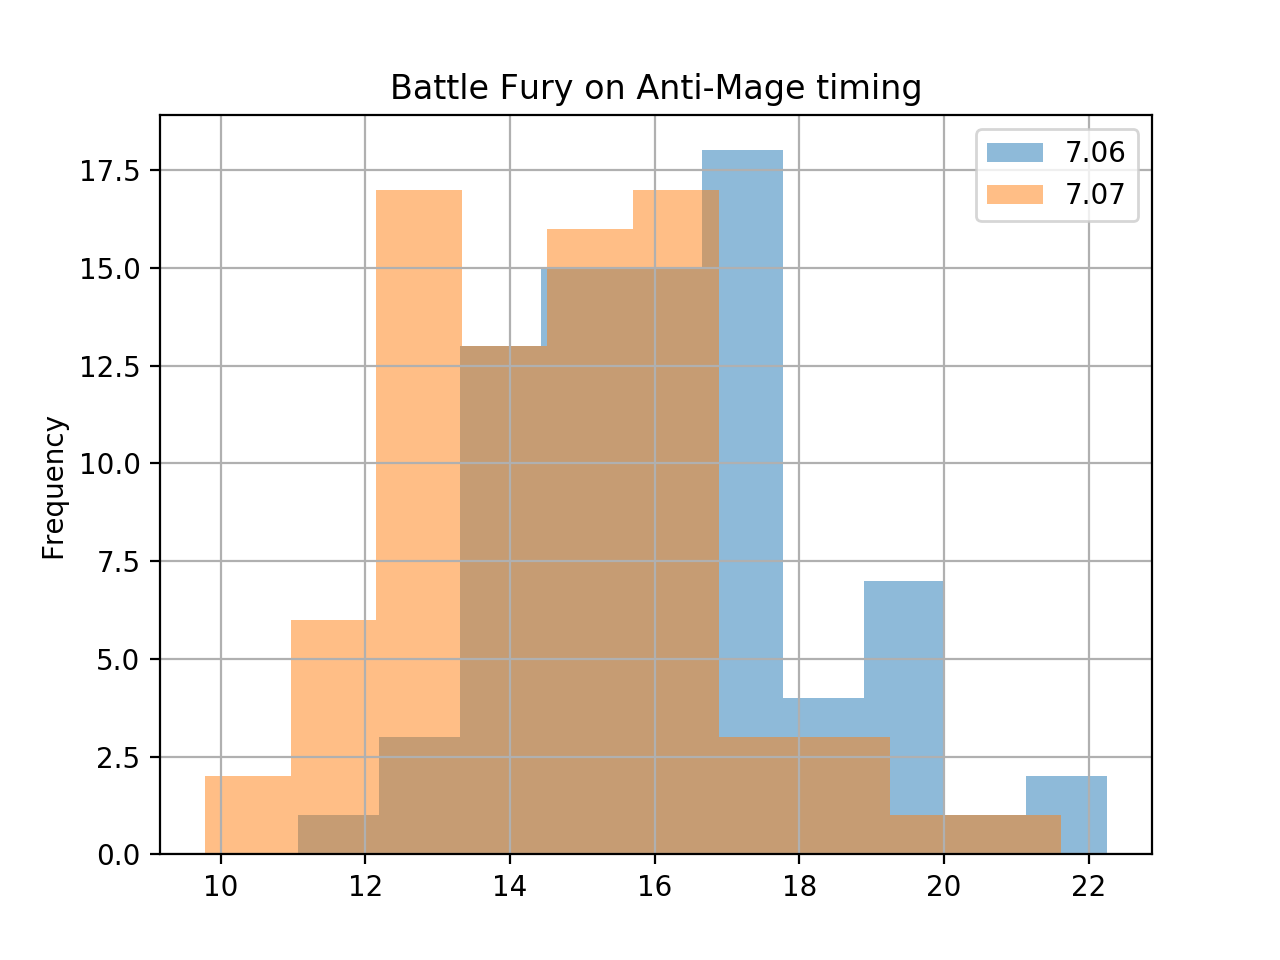

In [8]:
fig, ax = plt.subplots()
(bf_706 / 60).plot(kind='hist', grid=True, alpha=0.5, ax=ax)
(bf_707 / 60).plot(
    kind='hist', title='Battle Fury on Anti-Mage timing',
    grid=True, alpha=0.5, ax=ax)
plt.legend(['7.06', '7.07'])

In [15]:
from statsmodels.stats.diagnostic import kstest_normal
print('p_value: ', kstest_normal((bf_706 - bf_706.mean()) / bf_706.std())[1])
print('p_value: ', kstest_normal((bf_707 - bf_707.mean()) / bf_707.std())[1])

p_value:  0.513798711963
p_value:  0.470833353404


Данные распределены нормально, поэтому можно использовать t-test, предварительно сравнив дисперсии. В целях экономии времени используется ранговый тест Вилкоксона.

In [9]:
from scipy.stats import wilcoxon
wilcoxon(bf_707, bf_706)

WilcoxonResult(statistic=691.5, pvalue=1.4106707531234195e-05)

Гипотеза отвергается, можно утверждать, что предмет в новом патче покупается быстрее.